# Importing necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 
import nltk
import heapq
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from matplotlib.pyplot import figure
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import os 
import pandas as pd
import json
from tqdm import tqdm,tqdm_notebook
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
%matplotlib inline

# 1. --------Data Cleaning--------

In [ ]:
# load the meta data from the CSV file 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

#show 10 lines of the new dataframe
print (df.shape)
df.head(10)

(45774, 5)
(34809, 5)


,title,doi,abstract,publish_time,authors
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen
5,The infant airway microbiome in health and dis...,10.1101/012070,the nasopharynx (np) is a reservoir for microb...,2014-12-02,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...
6,Using heterogeneity in the population structur...,10.1101/017178,"abstractin 2013, u.s. swine producers were con...",2015-03-27,Eamon B. O’Dea; Harry Snelson; Shweta Bansal
7,"Big city, small world: Density, contact rates,...",10.1101/018481,macroscopic descriptions of populations common...,2015-04-27,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...
8,MERS-CoV recombination: implications about the...,10.1101/020834,recombination is a process that unlinks neighb...,2015-06-12,Gytis Dudas; Andrew Rambaut
9,On the causes of evolutionary transition:trans...,10.1101/027722,a pattern in which nucleotide transitions are ...,2015-09-28,Arlin Stoltzfus; Ryan W. Norris


In [ ]:
#Determining the shape of the dataset in the analysis
df.shape

(34809, 5)

**Creating series of functions to format and clean the data and form a short summary based on the keyword list given. (To be used in the last section of the assignment)**

In [ ]:
abstracts = df['abstract'].values

In [ ]:
#Series of functions to format and clean the data and form a short summary based on the keyword list given. (To be used in the last section of the assignment)
def word_freq(formatted_text):
    #creates a dictionary of words as keys and frequency as values
    word_frequencies = {}
    for word in nltk.word_tokenize(formatted_text):
        if word not in stopwords.words():
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

    maximum_frequency = max(word_frequencies.values())
    #divides the values by the maximum frequency
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
    
    return word_frequencies

def sent_scores(sentence_list, word_frequencies):
    #uses the word frequencies to score the sentences by adding up the scores
    #of the words that make up the sentence
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) <60: #limits sentence to less than 60 words
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
                    
    return sentence_scores

def clean_text(text):
    # Removing Square Brackets and Extra Spaces
    text = re.sub(r'\[[0-9]*\]',' ', text)
    text = re.sub(r'\s+',' ', text)
 
    text = re.sub(r'\{\{[\s\S]*?\}\}', '', text)

    # Remove doi links
    #text = re.sub(r'^https://$', '',text)
    return text

def clean_spchar_digs(text):
    # Removing special characters and digits
    text = re.sub('[^a-zA-Z]', ' ', text )
    text = re.sub(r'\s+', ' ', text)
    
    return text

def get_summary(dirty_text):
    '''
    Input: text that is already filtered for desired keywords
    '''
   
    #cleans the text
    text = clean_text(dirty_text)
    #remove special chars and nums
    formatted_text = clean_spchar_digs(text)
    #tokenize
    sentence_list = nltk.sent_tokenize(text)
    #wordfrequencies
    word_frequencies = word_freq(formatted_text)
    #dictionary of sentences with sentence as key and word frequency score as value
    sentence_scores = sent_scores(sentence_list,word_frequencies)
    
    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get) #first value is number highest scoring sentences to print
    summary = '\n\n '.join(summary_sentences)
    return summary

def get_summary_improved(searchlist):
    #get summary where all you have to do is provide the words you are searching for in a list
    covid_alias = ['CoV', 'COVID', 'Covid', 'corona virus', 'coronavirus', 'Coronavirus', 'Corona virus'] #depending on here the results w
    desired_sents = {}
    covid_sents = {}
    for text in abstracts:
        for sentence in text.split('. '):
            for i in searchlist:
                if i.lower() in sentence.lower(): #using .lower changes the results dramatically
                    if sentence not in desired_sents.keys():
                        desired_sents[sentence] = sentence 
            for j in covid_alias:
                if j in sentence:
                    if sentence not in covid_sents.keys():
                        covid_sents[sentence] = sentence
    desired_sents = set(desired_sents.keys())
    covid_sents = set(covid_sents.keys())
    desired_sents = list(desired_sents.intersection(covid_sents))
    
    desired_text = ''
    for x in desired_sents:
        desired_text += ' ' + x
    text = clean_text(desired_text)
    formatted_text = clean_spchar_digs(text)

    sentence_list = nltk.sent_tokenize(text)

    word_frequencies = word_freq(formatted_text) 
    sentence_scores = sent_scores(sentence_list,word_frequencies)
    
    
    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get) #first value is number highest scoring sentences to print
    summary = '\n\n '.join(summary_sentences)
    return summary


# --------2. Data Visualization and Exploratory Data Analysis--------

**2.1 Incubation Time Analysis**

In [ ]:
#Making a dataframe for incubation time analysis for COVID-19 
incubation = df[df['abstract'].str.contains('incubation')]
incubation

,title,doi,abstract,publish_time,authors
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen
54,Quantifying the Risk and Cost of Active Monito...,10.1101/156497,abstractduring outbreaks of deadly emerging pa...,2017-06-28,Nicholas G Reich; Justin Lessler; Jay K Varma;...
110,Incubation Period and Other Epidemiological Ch...,10.1101/2020.01.26.20018754,the geographic spread of 2019 novel coronaviru...,2020-01-28,Natalie M. Linton; Tetsuro Kobayashi; Yichi Ya...
114,The incubation period of 2019-nCoV infections ...,10.1101/2020.01.27.20018986,"currently, a novel coronavirus 2019-ncov cause...",2020-01-28,Jantien A. Backer; Don Klinkenberg; Jacco Wall...
139,Effectiveness of airport screening at detectin...,10.1101/2020.01.31.20019265,as the number of novel coronavirus cases grows...,2020-02-02,Billy Quilty; Sam Clifford; Stefan Flasche; Ro...
150,Serial interval of novel coronavirus (2019-nCo...,10.1101/2020.02.03.20019497,objective: to estimate the serial interval of ...,2020-02-13,Hiroshi Nishiura; Natalie M Linton; Andrei R. ...
157,Machine learning using intrinsic genomic signa...,10.1101/2020.02.03.932350,"abstractas of february 20, 2020, the 2019 nove...",2020-02-04,Gurjit S. Randhawa; Maximillian P.M. Soltysiak...
176,Analysis of the epidemic growth of the early 2...,10.1101/2020.02.06.20020941,"background: on january 23, 2020, a quarantine ...",2020-02-09,Qingyuan Zhao; Yang Chen; Dylan S Small
177,Clinical characteristics of 2019 novel coronav...,10.1101/2020.02.06.20020974,"background: since december 2019, acute respira...",2020-02-09,Wei-jie Guan; Zheng-yi Ni; Yu Hu; Wen-hua Lian...
181,"The Novel Coronavirus, 2019-nCoV, is Highly Co...",10.1101/2020.02.07.20021154,the novel coronavirus (2019-ncov) is a recentl...,2020-02-11,Steven Sanche; Yen Ting Lin; Chonggang Xu; Eth...


In [ ]:
#Finding the keywords pertaining to incubation time analysis for COVID-19
incubation_texts = incubation['abstract'].values
print("Number of paper abstracts in which incubation period keywords were found : ",len(incubation_texts))
incubation_times = []
incubation_dict = {}
for t in incubation_texts:
    for sentence in t.split('. '):
        if 'incubation' in sentence:

            single_day = re.findall(r" \d{1,2} day", sentence)
            if len(single_day) == 1:
                num = single_day[0].split(" ")
                incubation_times.append(float(num[1]))
                incubation_dict[sentence] = float(num[1])

Number of paper abstracts in which incubation period keywords were found :  407


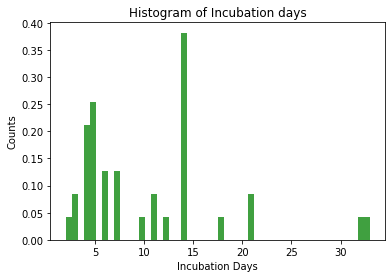

In [ ]:
#Visualization for the incubation time analysis of COVID-19 to draw some conclusions
n, bins, patches = plt.hist(incubation_dict.values(),50,density = True, facecolor='g', alpha=0.75)
plt.xlabel('Incubation Days')
plt.ylabel('Counts')
plt.title('Histogram of Incubation days')
plt.show()

**OBSERVATION** - The visualization for the incubation period shows that a maximum incubation period of 14 days is good enough to contain the spread of the virus and help the person infected to be on the path to make some progress on the recovery, which corroborates to the present findings of the researchers. 

**2.2 Seasonality Analysis**

In [ ]:
#Making a dataframe for the seasonality analysis for COVID-19
seasonality = df[df['abstract'].str.contains('season')]
seasonality

,title,doi,abstract,publish_time,authors
39,Epidemiological and ecological modelling revea...,10.1101/099069,abstractrespiratory tract infections (rti) are...,2017-01-09,Abigail L. Coughtrie; Denise E. Morris; Rebecc...
55,Automated collection of pathogen-specific diag...,10.1101/157156,abstracthealth-care and public health professi...,2017-07-31,Lindsay Meyers; Christine C. Ginocchio; Aimie ...
59,MERS-CoV spillover at the camel-human interface,10.1101/173211,abstractmiddle east respiratory syndrome coron...,2017-08-10,Gytis Dudas; Luiz Max Carvalho; Andrew Rambaut...
107,Under-the-radar dengue virus infections in nat...,10.1101/2020.01.24.919282,abstractthe incidence of locally acquired deng...,2020-01-25,Sean M. Boyles; Carla N. Mavian; Esteban Finol...
129,Direct Measurement of Rates of Asymptomatic In...,10.1101/2020.01.30.20019612,the pandemic potential of the novel coronaviru...,2020-02-03,Jeffrey Shaman; Marta Galanti
234,A spatial model of CoVID-19 transmission in En...,10.1101/2020.02.12.20022566,background: an outbreak of a novel coronavirus...,2020-02-14,Leon Danon; Ellen Brooks-Pollock; Mick Bailey;...
243,Potential impact of seasonal forcing on a SARS...,10.1101/2020.02.13.20022806,a novel coronavirus (sars-cov-2) first detecte...,2020-02-17,Richard A Neher; Robert Dyrdak; Valentin Druel...
454,Precautions are Needed for COVID-19 Patients w...,10.1101/2020.02.29.20027698,background: with the ongoing outbreak of coron...,2020-03-03,Quansheng Xing; Guoju Li; Yuhan Xing; Ting Che...
481,Effects of weather-related social distancing o...,10.1101/2020.03.02.20027599,background: unusually high snowfall in western...,2020-03-03,Michael L Jackson; Gregory R Hart; Denise J Mc...
484,The Seattle Flu Study: a multi-arm community-b...,10.1101/2020.03.02.20029595,introduction. influenza epidemics and pandemic...,2020-03-06,Helen Y. Chu; Michael Boeckh; Janet A. Englund...


In [ ]:
#Finding the keywords pertaining to seasons (summer, winter, spring, fall)
seasonality_texts = seasonality['abstract'].values
print("Number of paper abstracts in which season keywords were found : ", len(seasonality_texts))
season_data = ''
for t1 in seasonality_texts:
    for sentence1 in t1.split('. '):
        if 'season' in sentence1:
            if 'winter' in sentence1 or 'summer' in sentence1 or 'fall' in sentence1 or 'spring' in sentence1:
#                 print(sentence)
#                 print()
#                 print()
                    season_data += ' ' + sentence

Number of paper abstracts in which season keywords were found :  1150


In [ ]:
#Forming the dictionary of the found text in the dataset for facilitating the ease of using it for visualization
seasons = ['summer', 'winter', 'fall', 'spring']
seasons_dict = dict((s,0) for s in seasons)

print(seasons_dict)

for s in seasons_dict:
    for abstract in df['abstract']:
        if str(s) in abstract:
            seasons_dict[s] += 1


print(seasons_dict)

{'summer': 0, 'winter': 0, 'fall': 0, 'spring': 0}
{'summer': 193, 'winter': 381, 'fall': 303, 'spring': 287}


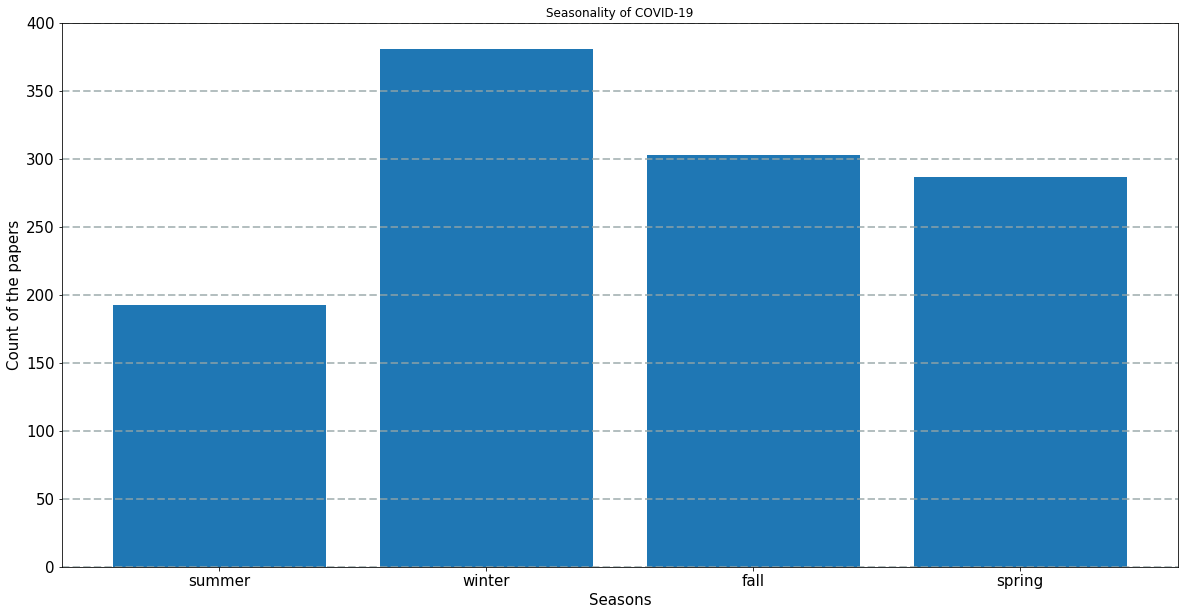

In [ ]:
#Visualization of the analysis for seasonality of COVID-19 to draw some conclusions
plt.figure(figsize= (20,10))
plt.bar(seasons_dict.keys(),seasons_dict.values(),width =0.8) #Plotting the bar plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Seasons',fontsize=15)
plt.ylabel('Count of the papers',fontsize=15)
plt.title('Seasonality of COVID-19')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

**OBSERVATION**- From the graph plotted above for the seasonality analysis of COVID-19, the virus seems to have a increase in intensity in the colder seasons, winter to count for most number of occurences in the research papers, followed by fall, spring and the least in the summer. Thus, from this analysis we can deduce that the virus has a spread of higher intensity in lesser temperatures, as suggested by the literature.

**2.3 History (Origin& Evolution) of the virus**

In [ ]:
#Making a dataframe for the seasonality analysis for COVID-19
history = df[df['abstract'].str.contains('history', 'natural history')]
history

,title,doi,abstract,publish_time,authors
17,Fractional Dosing of Yellow Fever Vaccine to E...,10.1101/053421,backgroundthe ongoing yellow fever (yf) epidem...,2016-05-14,Joseph T. Wu; Corey M. Peak; Gabriel M. Leung;...
28,Containing Emerging Epidemics: a Quantitative ...,10.1101/072652,abstractstrategies for containing an emerging ...,2016-08-31,Corey M Peak; Lauren M Childs; Yonatan H Grad;...
105,Complete genome characterisation of a novel co...,10.1101/2020.01.24.919183,"emerging and re-emerging infectious diseases, ...",2020-01-25,Fan Wu; Su Zhao; Bin Yu; Yan-Mei Chen; Wen Wan...
110,Incubation Period and Other Epidemiological Ch...,10.1101/2020.01.26.20018754,the geographic spread of 2019 novel coronaviru...,2020-01-28,Natalie M. Linton; Tetsuro Kobayashi; Yichi Ya...
114,The incubation period of 2019-nCoV infections ...,10.1101/2020.01.27.20018986,"currently, a novel coronavirus 2019-ncov cause...",2020-01-28,Jantien A. Backer; Don Klinkenberg; Jacco Wall...
119,Estimated effectiveness of traveller screening...,10.1101/2020.01.28.20019224,traveller screening is being used to limit fur...,2020-01-30,Katelyn Gostic; Ana C. R. Gomez; Riley O. Mumm...
149,Evidence and characteristics of human-to-human...,10.1101/2020.02.03.20019141,"background: on december 31, 2019, an outbreak ...",2020-02-05,Min Kang; Jie Wu; Wenjun Ma; Jianfeng He; Jing...
168,Bulk and single-cell transcriptomics identify ...,10.1101/2020.02.05.20020107,in current severe global emergency situation o...,2020-02-11,Guoshuai Cai
176,Analysis of the epidemic growth of the early 2...,10.1101/2020.02.06.20020941,"background: on january 23, 2020, a quarantine ...",2020-02-09,Qingyuan Zhao; Yang Chen; Dylan S Small
185,Exploring the coronavirus epidemic using the n...,10.1101/2020.02.07.939124,"abstractsince its debut in mid-december, 2019,...",2020-02-11,Jennifer A. Flynn; Deepak Purushotham; Mayank ...


In [ ]:
#Collecting the keywords regarding to histroy of thevirus in analysis
history_texts = history['abstract'].values
print("Number of papers in which history keywords were found : ", len(history_texts))
history_data = ''
for t2 in history_texts:
    for sentence2 in t2.split('. '):
        if 'history' in sentence2:
            if 'natural history' in sentence2 or 'diagnostics' in sentence2 or 'Cov' in sentence2 or 'Covid' in sentence2 or 'COVID' in sentence2 or 'corona virus' in sentence2:
#                 print(sentence)
#                 print()
#                 print()
                    history_data += ' ' + sentence2


Number of papers in which history keywords were found :  964


In [ ]:
#Forming the dictionary of the found text in the dataset for facilitating the ease of using it for visualization
history = ['natural evolution','history', 'natural history', 'diagnostics','livestock', 'animals', 'hosts', 'spillover', 'suscept','field surveillance', 'genetic sequencing', 'receptor binding','strain']
history_dict = dict((hist,0) for hist in history)

print(history_dict)

for hist in history_dict:
    for abstract in df['abstract']:
        if str(hist) in abstract:
            history_dict[hist] += 1


print(history_dict)

{'natural evolution': 0, 'history': 0, 'natural history': 0, 'diagnostics': 0, 'livestock': 0, 'animals': 0, 'hosts': 0, 'spillover': 0, 'suscept': 0, 'field surveillance': 0, 'genetic sequencing': 0, 'receptor binding': 0, 'strain': 0}
{'natural evolution': 4, 'history': 964, 'natural history': 81, 'diagnostics': 492, 'livestock': 316, 'animals': 2259, 'hosts': 884, 'spillover': 116, 'suscept': 1780, 'field surveillance': 4, 'genetic sequencing': 9, 'receptor binding': 245, 'strain': 4316}


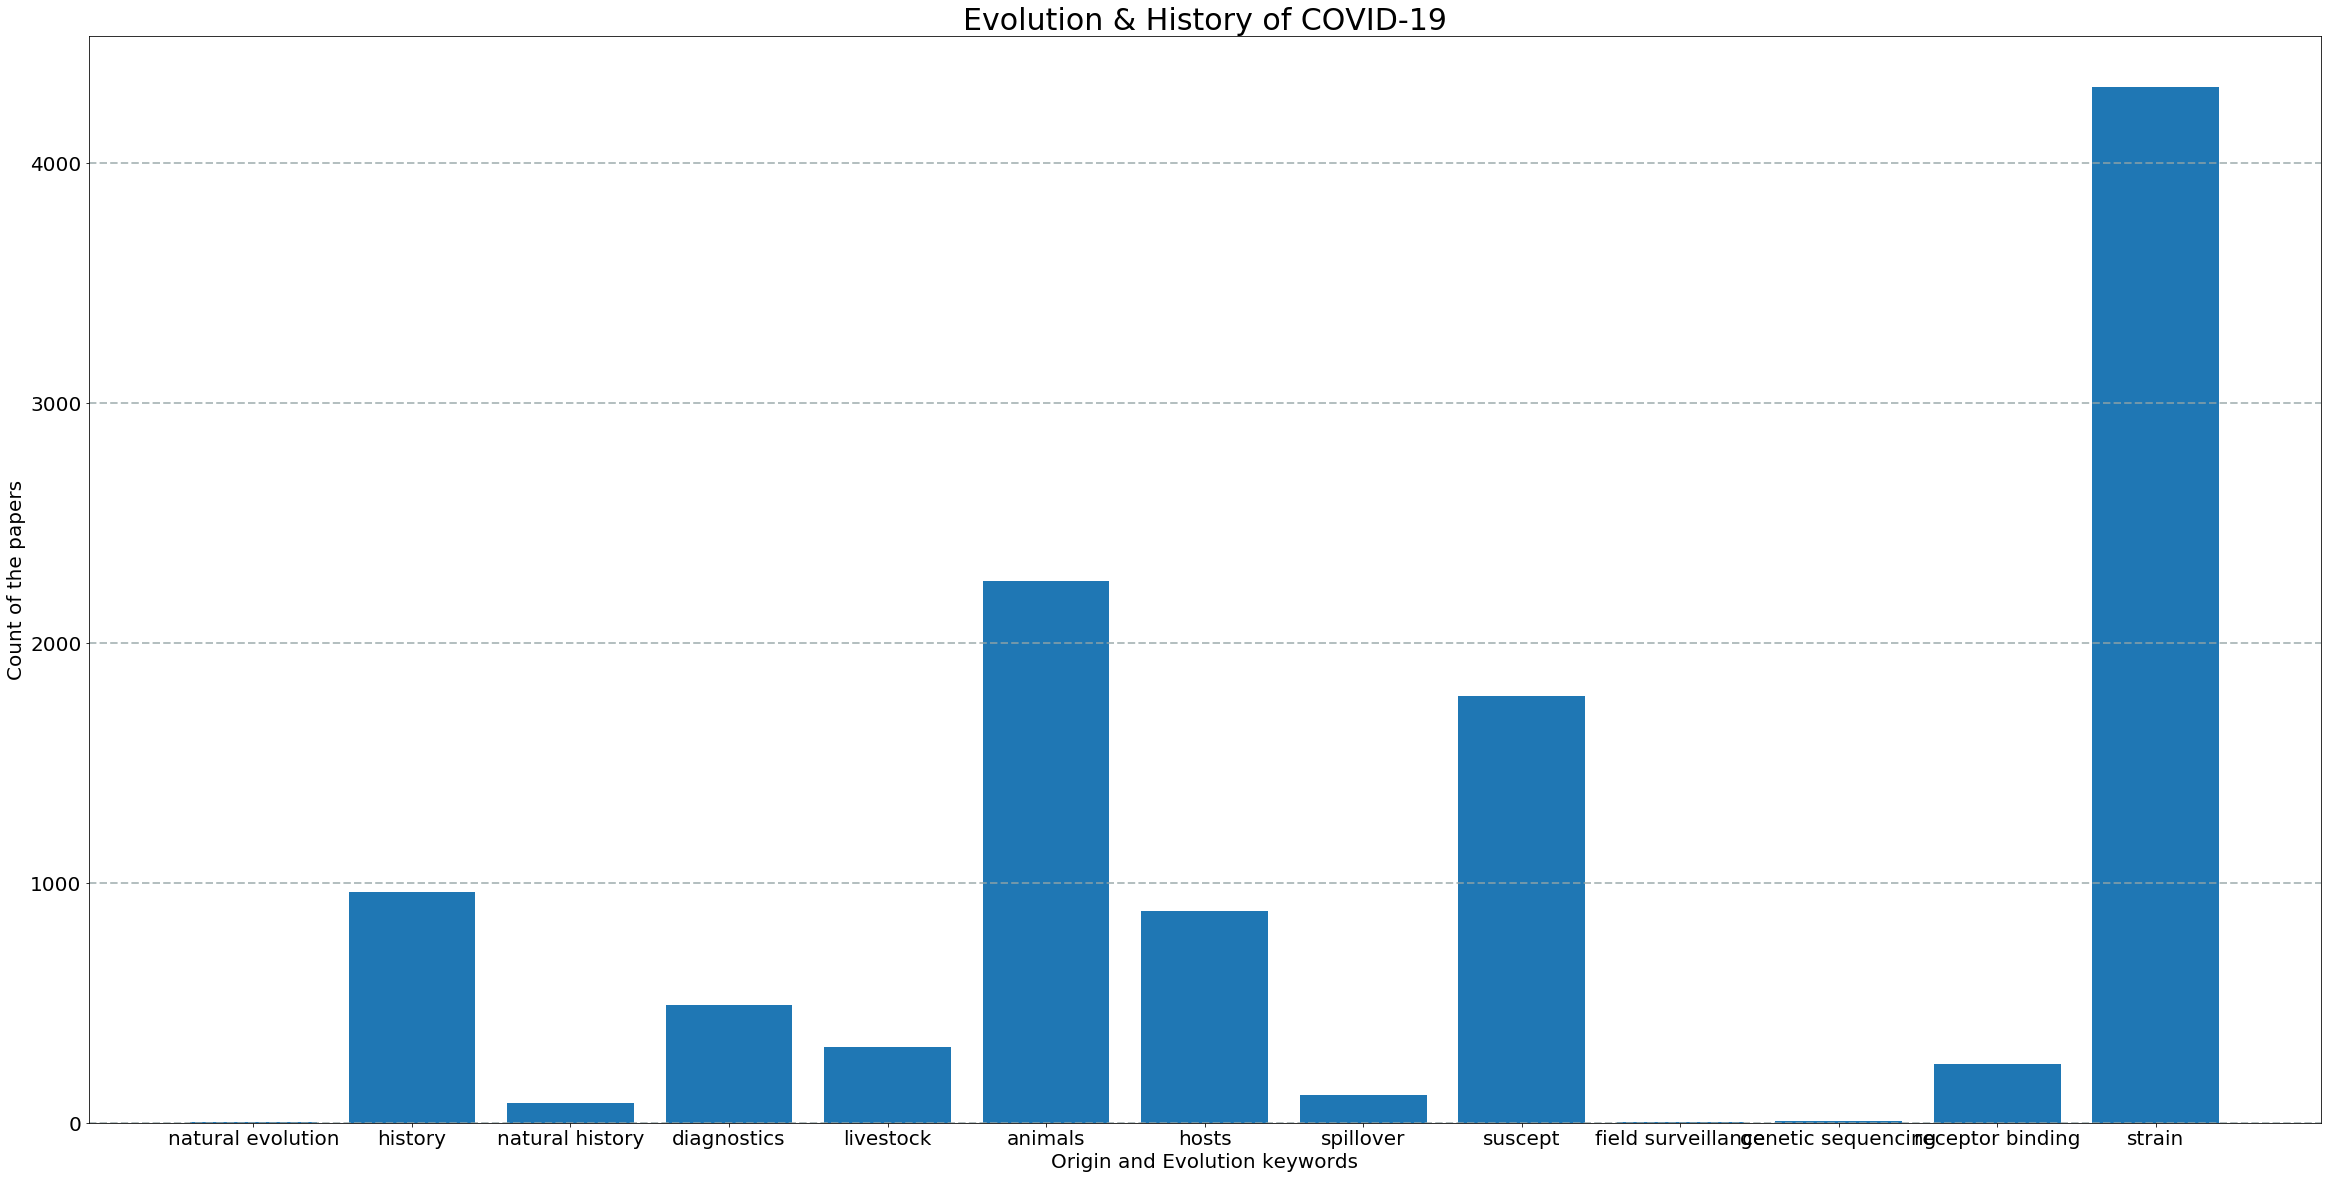

In [ ]:
#Visualization of the analysis for seasonality of COVID-19 to draw some conclusions
plt.figure(figsize= (40,20))
plt.bar(history_dict.keys(),history_dict.values(),width =0.8) #Plotting the bar plot
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Origin and Evolution keywords', fontsize = 20)
plt.ylabel('Count of the papers',fontsize = 20)
plt.title('Evolution & History of COVID-19',fontsize = 30)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

**OBSERVATION** - From the analysis of Origin & Evaluation for COVID-19, the plot above shows the frequency of the keywords obtained in the dataset. It was seen that the keywords of strain had the highest frequency among all and thus we can deduce that the COVID-19 virus was a strain of virus different from its predecessors of SARS virus, although both the virus target the respiratory system of humans. It can also be deduced that animals in small amounts could have been the carriers of a strain of COVID-19 virus.

**2.4 Risk factors of COVID-19**

In [ ]:
#Forming the dictionary of the found text in the dataset for facilitating the ease of using it for visualization
risk = ['risk factors', 'high risk', 'at risk', 'susceptible','smoking','pulmonary','morbidities', 'coinfection','mitigation measure']
risk_dict = dict((ris,0) for ris in risk)

print(risk_dict)

for ris in risk_dict:
    for abstract in df['abstract']:
        if str(ris) in abstract:
            risk_dict[ris] += 1


print(risk_dict)

{'risk factors': 0, 'high risk': 0, 'at risk': 0, 'susceptible': 0, 'smoking': 0, 'pulmonary': 0, 'morbidities': 0, 'coinfection': 0, 'mitigation measure': 0}
{'risk factors': 622, 'high risk': 248, 'at risk': 257, 'susceptible': 1089, 'smoking': 115, 'pulmonary': 1082, 'morbidities': 236, 'coinfection': 262, 'mitigation measure': 10}


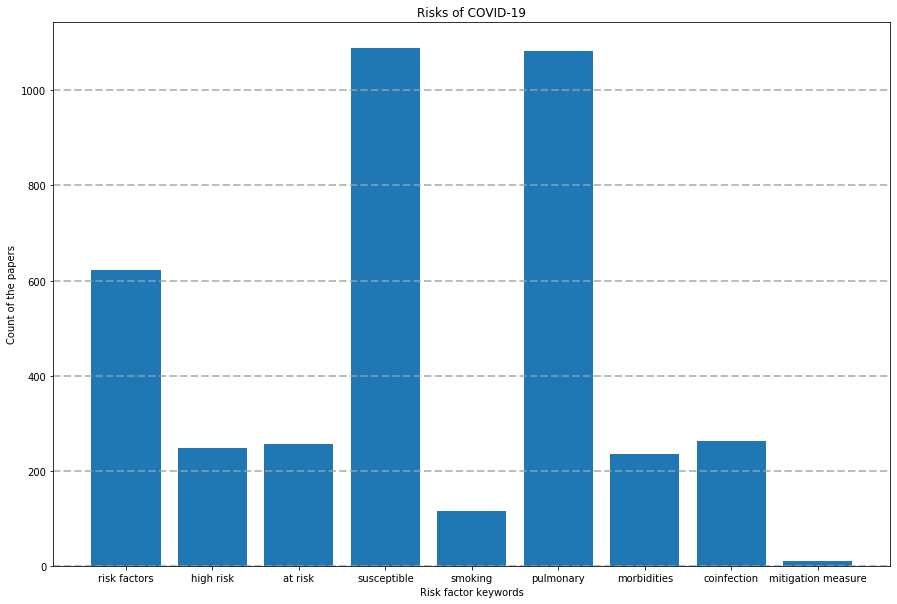

In [ ]:
#Visualization of the analysis for seasonality of COVID-19 to draw some conclusions
plt.figure(figsize= (15,10))
plt.bar(risk_dict.keys(),risk_dict.values(),width =0.8) #Plotting the bar plot
plt.xlabel('Risk factor keywords')
plt.ylabel('Count of the papers')
plt.title('Risks of COVID-19')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

**OBSERVATION**- From the analysis of risk factors from COVID-19 the keywords analysis showed a greater number of risk in terms of pulmonary diseases (relating to the respiratory system), and also showed that people highly susceptible to these kind of diseases have the higher chances of catching the virus. The risk factors includes morbidities(number of deaths), but it is not as high. The chances of coinfection(catching a virus in addition to COVID-19) is greater than that of morbidity but overall is lesser than the threat of this virus to the pulmonary disease patients.

In [ ]:
#Function for the generation of wordcloud
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

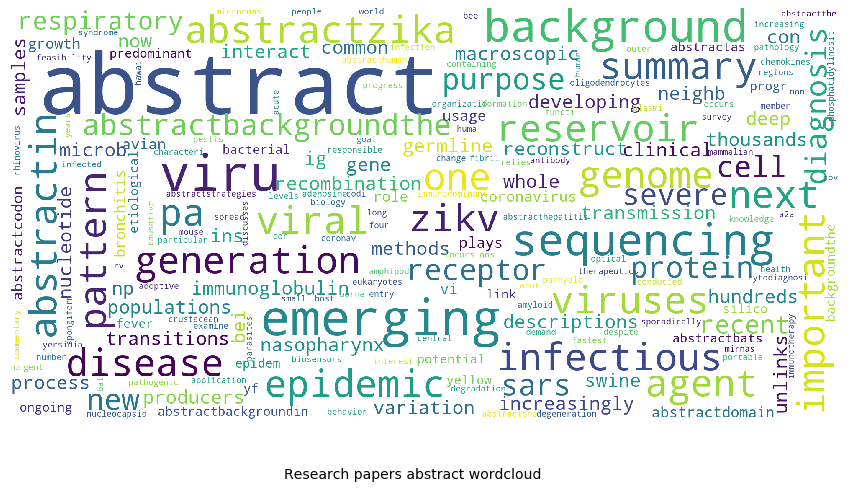

In [ ]:
#Wordcloud for finding the major keywords in abstract column of the dataset
show_wordcloud(df['abstract'], title = 'Research papers abstract wordcloud')

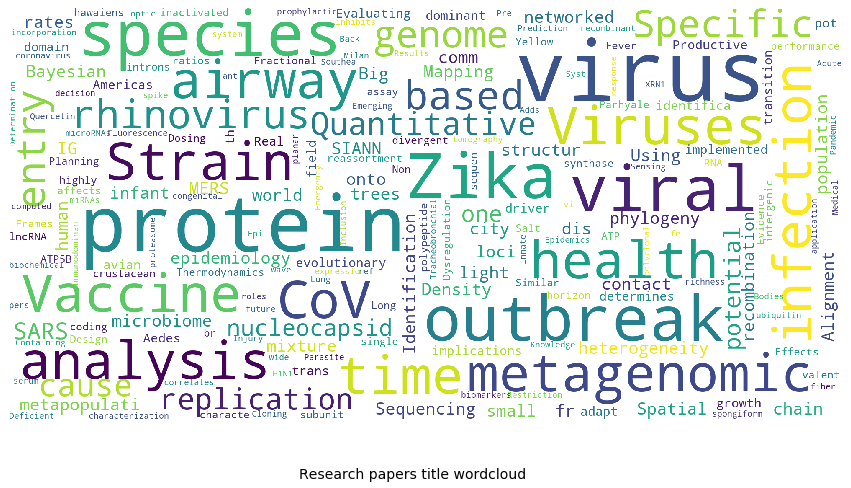

In [ ]:
#Wordcloud for finding the major keywords in title column of the dataset
show_wordcloud(df['title'], title = 'Research papers title wordcloud')

# --------3. Model Implementation--------

In [ ]:
#Applting Tf-idf Vectorizer
abst = df['abstract']
#Applying the Tf-idf Vectorizer here for further analysis
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(abst)

Reference: https://analyticsindiamag.com/beginners-guide-to-k-means-clustering/

**Choosing the numer of clusters in K-means clustering**

The number of clusters that we choose for a given dataset cannot be random. Each cluster is formed by calculating and comparing the distances of data points within a cluster to its centroid. An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS). 

WCSS is the sum of squares of the distances of each data point in all clusters to their respective centroids.The idea is to minimise the sum. Suppose there are n observation in a given dataset and we specify n number of clusters (k = n) then WCSS will become zero since data points themselves will act as centroids and the distance will be zero and ideally this forms a perfect cluster, however this doesn’t make any sense as we have as many clusters as the observations. Thus there exists a threshold value for K which we can find using the Elbow point graph.



In [ ]:
#WCSS analysis
wcss = []
for i in range(1,12):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=100,n_init=1,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

**Elbow method**

We can find the optimum value for K using an Elbow point graph. We randomly initialise the K-Means algorithm for a range of K values and will plot it against the WCSS for each K value.For the above-given graph, the optimum value for K would be 7. As we can see that with an increase in the number of clusters the WCSS value decreases. We select the value for K on the basis of the rate of decrease in WCSS. For example, from cluster 1 to 6 in the graph below we see a sudden and huge drop in WCSS. After 7 the drop is minimal and hence we chose 7 to be the optimal value for K.

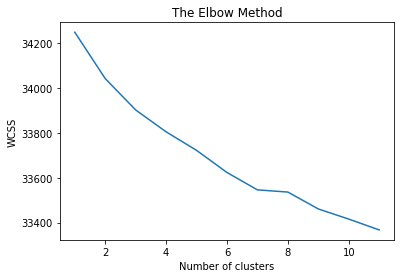

In [ ]:
#Plot for the Elbow Method
plt.plot(range(1,12),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.savefig('elbow.png')
plt.show()

In [ ]:
#Reference: https://pythonprogramminglanguage.com/kmeans-text-clustering/

true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Y = vectorizer.transform(abst)
prediction = model.predict(Y)
print(prediction)


Top terms per cluster:
Cluster 0:
 protein
 proteins
 virus
 cells
 cell
 binding
 activity
 fusion
 viral
 membrane
Cluster 1:
 health
 public
 disease
 outbreak
 epidemic
 transmission
 infectious
 diseases
 cases
 china
Cluster 2:
 cov
 sars
 mers
 coronavirus
 respiratory
 syndrome
 protein
 severe
 east
 middle
Cluster 3:
 rna
 viruses
 viral
 virus
 host
 replication
 genome
 proteins
 protein
 cellular
Cluster 4:
 patients
 respiratory
 influenza
 children
 infections
 viruses
 rsv
 virus
 viral
 clinical
Cluster 5:
 cells
 ifn
 immune
 infection
 cell
 mice
 il
 virus
 response
 responses
Cluster 6:
 virus
 disease
 samples
 clinical
 study
 infection
 abstract
 strains
 pedv
 vaccine


Prediction
[6 1 6 ... 4 1 2]


**Possible Insights of the Cluster formations**

**Cluster 0** - This cluster has the keywords relating to how COVID-19 propogates inside the body of the patient. The proteins interact with the viral membrane protein during the assembly and plays a role in the virus budding. Other type of protein helps in facilitating the viral entry into host cell by combination of the host and the viral cell membranes.

**Cluster 1** - This cluster has the keywords regarding the transmission of the virus (COVID-19). The disease started from China and spread as the people who were infected began going in different countries. By the time the virus was diagnosed and analysed to be infectious, it already was intensely spread to a larger public, leading to an epidemic and possibly a pandemic at much later stage. The outbreak of the virus was rather more significant to cases having an underlying health issue.

**Cluster 2** - This cluster has the keywords regarding the similarity of COVID-19 with SARS(Severe Acute Respiratory Syndrome) and MERS(Middle East Respiratory Syndrome). All forms of the virus mentined attack the respiratory system of the ones affected and can result severe and fatal conditions, sometimes even leading to death.

**Cluster 3** - This cluster has the keywords relating to the genome(gene structure) of COVID-19 and explores the aspect regarding the replication of the virus. Exploring the possibility of the genome of COVID-19 helps to ascertain and determine the possibility of the virus being synthetic or natural. It further suggest that COVID-19 is a RNA based virus, meaning it temporarily stors its DNA in RNA like other species of viruses causing influenza.

**Cluster 4** - This cluster has the keywords regarding the resemblance of the COVID-19 to other similar viruses like that of the influenza and respiratory syncytial virus (rsv). It suggests that like other viruses, COVID-19 is also a clinical virus and needs to be properly treated, otherwise can prove fatal. Children are most likely to be prone to get infected with this virus, as they demonstrate an undeveloped immunity towards viruses much less intense than COVID-19 such as rsv, influenza.

**Cluster 5**- This clusters has the keywords which shows the attempted development of the vaccines to treat COVID-19. As the viral cells directly attack the healthy cells in the body, interfernons(ifn), a group of signaling proteins,signals the body for creating antibodies to fight the unknown entity present in the body. Although there have been several attempts to create vaccines for this virus, a fully successful one hasn't been developed yet. The vaccines are expected to go in the first testing phase in the coming months.
 
**Cluster 6**- This cluster has the keywords which explores the possibility of studying the characteristics of COVID-19 based on its strain viruses such as PEDV(Porcine Epidemic Diarrhea Virus) for the possibility of making a successful attempt at developing a vaccine against COVID-19. Further the possibility of transmission of COVID-19 through livestock is also being analyzed unlike pedv, whose source is the breeding animals. 

# --------4. Deriving insights about policy and guidance to tackle the outbreak based on model findings--------

Using the functions created in the first sections-Data Cleaning in order to get a short summary based on the keywords.

**Insights obtained from the cluster analysis**

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 0 from the k-means clustering implemented above
slist_cluster0 = ['protein','proteins','virus','cells','cell','binding','activity','fusion','viral','membrane']
cluster0_sum = get_summary_improved(slist_cluster0)
print(cluster0_sum)

abstract severe acute respiratory syndrome (sars) is a respiratory disease caused by a newly found virus, called sars coronavirus this risk has been recently reinforced by human epidemics in singapore of sars coronavirus, 2009 pandemic h1n1 influenza a virus, and enterovirus 71 possible dispersal mechanisms as to how coronaviruses arrived on madagascar are discussed.

 additional new respiratory viruses detected during follow-up of these 15 patients included rhinovirus (3), metapneumovirus (2), coronavirus (1), respiratory syncytial virus (1), parainfluenza virus (1), and adenovirus (1) we propose that coronavirus ntds originated from a host galectin and retained sugar-binding functions in some contemporary coronaviruses, but evolved new structural features in mhv for mceacam1a binding.

 the present work presents the first review of the fatal novel coronavirus cases in china this review gives an example of one such vaccine platform, replication-deficient simian adenoviruses, and descr

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 1 from the k-means clustering implemented above
slist_cluster1 = ['health','public','disease','outbreak','epidemic','transmission','infectious','diseases','cases','china']
cluster1_sum = get_summary_improved(slist_cluster1)
print(cluster1_sum)

summary background in december, 2019, a pneumonia associated with the 2019 novel coronavirus (2019-ncov) emerged in wuhan, china background: since late december 2019, novel coronavirus-infected pneumonia (ncp) emerged in wuhan, hubei province, china recently, some media outlets inappropriately labelled the coronavirus by race, using such headlines as ?chinese virus pandemonium?

 the outbreak of a novel coronavirus infection can lead to 15% ~ 30% patients developing into acute respiratory distress syndrome (ards) using as an example the coronavirus disease 2019 (covid-19) epidemic, we (a) examine challenges associated with what we term ?global information crises?

 coronavirus has a history of causing epidemics in human and animals sars-cov-2 is a coronavirus associated with the epidemiological outbreak in late 2019 the newly identified coronavirus in the most-trafficked mammal could represent a continuous threat to public health if wildlife trade is not effectively controlled.

 the s

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 2 from the k-means clustering implemented above
slist_cluster2 = ['cov','mers','coronavirus','respiratory','syndrome','severe','east','middle']
cluster2_sum = get_summary_improved(slist_cluster2)
print(cluster2_sum)

abstract severe acute respiratory syndrome (sars) is a respiratory disease caused by a newly found virus, called sars coronavirus this risk has been recently reinforced by human epidemics in singapore of sars coronavirus, 2009 pandemic h1n1 influenza a virus, and enterovirus 71 possible dispersal mechanisms as to how coronaviruses arrived on madagascar are discussed.

 additional new respiratory viruses detected during follow-up of these 15 patients included rhinovirus (3), metapneumovirus (2), coronavirus (1), respiratory syncytial virus (1), parainfluenza virus (1), and adenovirus (1) we propose that coronavirus ntds originated from a host galectin and retained sugar-binding functions in some contemporary coronaviruses, but evolved new structural features in mhv for mceacam1a binding.

 the present work presents the first review of the fatal novel coronavirus cases in china this review gives an example of one such vaccine platform, replication-deficient simian adenoviruses, and descr

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 3 from the k-means clustering implemented above
slist_cluster3 = ['rna','viruses','host','replication','genome','cellular']
cluster3_sum = get_summary_improved(slist_cluster3)
print(cluster3_sum)

moreover, these compounds also inhibit the replication of sars coronavirus and human coronavirus 229e zika virus (zikv), ebola virus (ebov), severe acute respiratory syndrome coronavirus (sars-cov), and middle east respiratory syndrome coronavirus (mers-cov) as (re-)emerging viral pathogens and other enveloped viruses could be efficiently inactivated by both who formulations, implicating their use in healthcare systems and viral outbreak situations.

 additional new respiratory viruses detected during follow-up of these 15 patients included rhinovirus (3), metapneumovirus (2), coronavirus (1), respiratory syncytial virus (1), parainfluenza virus (1), and adenovirus (1) we propose that coronavirus ntds originated from a host galectin and retained sugar-binding functions in some contemporary coronaviruses, but evolved new structural features in mhv for mceacam1a binding.

 infection with gammaherpesviruses, alphaherpesviruses, and betacoronaviruses can result in widespread mrna degradati

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 4 from the k-means clustering implemented above
slist_cluster4 = ['influenza','children','infections','rsv','clinical']
cluster4_sum = get_summary_improved(slist_cluster4)
print(cluster4_sum)

pneumoniae, rhinovirus, respiratory syncytial virus (rsv), influenza virus, metapneumovirus, adenovirus’, parainfluenza virus and coronavirus in acute respiratory tract infections in children the most commonly acquired respiratory viruses were human rhinovirus, followed by human coronaviruses and influenza a virus, in decreasing order cordata has much potential for the development of antiviral agents against coronavirus and dengue infections.

 the pathogens, including influenza virus, respiratory syncytial virus (rsv), rhinovirus (hrv), adenovirus (adv), herpes simplex virus (hsv), human coronavirus (hcov), streptococcus pneumoniae and haemophilus influenzae, were detected by real-time pcr future studies should explore links between the timing of coronavirus infections and subsequent development of schizophrenia and other disorders with psychotic symptoms.

 purpose to investigate the clinical, laboratory, and imaging findings of emerging coronavirus 2019-ncov pneumonia in humans duri

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 5 from the k-means clustering implemented above
slist_cluster5 = ['cells','ifn','immune','cell','mice','il','response','responses']
cluster5_sum = get_summary_improved(slist_cluster5)
print(cluster5_sum)

the pipeline has been validated on human immunodeficiency virus, human parainfluenza virus 1-4, human metapneumovirus, human coronaviruses (229e/oc43/nl63/hku1/sars/mers), human enteroviruses/rhinoviruses, measles virus, mumps virus, hepatitis a-e virus, chikungunya virus, dengue virus, and west nile virus, as well the human polyomaviruses bk/jc/mcv, human adenoviruses, and human papillomaviruses these data greatly extend our knowledge of wildlife reservoirs of alphacoronaviruses.

 soe also inhibited simian immunodeficiency virus infection but failed to block vesicular stomatitis virus, severe acute respiratory syndrome coronavirus, and influenza h5n1 pseudoviruses it is unclear whether newly reported viral respiratory pathogens (such as the middle east respiratory syndrome coronavirus, will be more of a problem in hiv-infected individuals than the general population.

 objective: to explore imaging characteristics of children with 2019 novel coronavirus (2019-ncov) infection intratra

In [ ]:
#Getting a short summary from the keywords obtained in the cluster 6 from the k-means clustering implemented above
slist_cluster6 = ['disease','samples','study','abstract','strains','pedv','vaccine']
cluster6_sum = get_summary_improved(slist_cluster6)
print(cluster6_sum)

sars-cov-2 is the novel coronavirus responsible for this disease abstract cultures of human rhabdomyosarcoma (rd) and human glioblastoma (u87-mg) were compared for their ability to sustain a persistent infection with coronavirus oc43 these cross-reactive mabs may serve as tools useful for sars-cov-2 research as well as for the development of diagnostic assays for its associated coronavirus disease covid-19.

 abstract the present study was to characterize turkey coronavirus associated with turkey poult enteritis and mortality the more recent design of wide-spectrum inhibitors targeting the coronavirus main proteases may lead to the discovery of new antivirals against multiple coronavirus induced diseases.

 we study epidemiological and clinical outcome of 55 asymptomatic carriers who were laboratory-confirmed positive for the sars-coronavirus-2 by testing the nucleic acid of the pharyngeal swab samples abstractsevere acute respiratory syndrome coronavirus 2 is rapidly spreading around 

**Insights about the vaccine from the analysis for COVID-19**

In [ ]:
#Getting summary for the keywords related to the vaccines from the dataset analysis
slist_vaccines = ['vaccines', 'therauptics', 'vaccine']
vaccines_sum = get_summary_improved(slist_vaccines)
print(vaccines_sum)

the spike (s) glycoprotein of severe acute respiratory syndrome coronavirus (sars-cov) mediates the receptor interaction and immune recognition and is considered a major target for vaccine design it is hoped that this approach will lead to the production of a superior commercial vaccine for the protection of neonatal calves against enteric coronavirus infection.

 developing effective and safe vaccines is urgently needed to prevent infection by severe acute respiratory syndrome (sars)–associated coronavirus (sars-cov) this study reveals a role for endou activity as a virulence factor in pedv infection and provides an approach for generating live-attenuated vaccine candidates for emerging coronaviruses.

 interpretation the gls-5300 mers coronavirus vaccine was well tolerated with no vaccine-associated serious adverse events conclusion: thus, monitoring of bovine coronavirus in ireland is important as the current isolates in circulation in the south of ireland may be diverging from the 

**Summary on the based for the analysis of sources of COVID-19, from the livestock**

In [ ]:
#Getting summary for the keywords related to the source, specifically livestock related sources from the dataset analysis
slist_livestock = ['livestock', 'animals', 'hosts', 'spillover', 'suscept']
livestock_sum = get_summary_improved(slist_livestock)
print(livestock_sum)

abstract coronaviruses (covs) are an important cause of illness in humans and animals importance coronaviruses cause widespread respiratory, gastrointestinal, and central nervous system diseases in humans and other animals, threatening human health and causing economic loss these data indicate that, depending upon route of immunization, mice can become susceptible to reinfection with the same coronavirus strain over time.

 dromedary camels are important reservoir hosts of various coronaviruses, including middle east respiratory syndrome coronavirus (mers-cov) that cause human infections ghanaian domestic livestock are not likely intermediate hosts of hcov-nl63-related coronaviruses.

 source identification requires detailed epidemiological studies of the infected patients and enhanced surveillance of mers-cov or similar coronaviruses in humans and animals these findings may provide important insights into devising therapeutic strategies and selection of antiviral compounds for further

**Summary on the based for the analysis of sources of COVID-19, based on the genetics of the virus**

In [ ]:
#Getting summary for the keywords related to the source, specifically genetics of the virus from the dataset analysis
slist_otherrsns = ['field surveillance', 'genetic sequencing', 'receptor binding']
otherrsns_sum =  get_summary_improved(slist)
print(otherrsns_sum)

like other coronaviruses such as the sars-cov, the 2019-ncov uses the receptor binding domain (rbd) of the surface spike glycoprotein (s protein) to engage ace2 this phenomenon could be extended to other betacoronaviruses utilizing ctd1 of the s1 subunit for receptor binding, which provides new insights into the intermediate states of coronavirus pre-fusion spike trimer during infection.

 we postulate that the versatility of cell receptor binding strategies has immediate implications on therapeutic strategies.one sentence summarymolecular dynamics simulations reveal a temporal dimension of coronaviruses interactions with the host receptor.

 moreover, cleavage was mapped to the same region where, in coronaviruses carrying furin-activated spikes, the receptor binding subunit of the protein is separated from the membrane-anchored fusion subunit.


**Summary on the based for the analysis of sources of COVID-19, based on the strains or species of the virus**

In [ ]:
# Getting summary for the keywords related to the source, specifically based on strains from the dataset analysis
slist_strains = ['strain']
strains_sum =  get_summary_improved(slist_strains)
print(strains_sum)

as the subgroup 2 strains have not been isolated for at least 20 years, it appears likely that an unknown avian coronavirus that was the donor of the s1 glycoprotein sequence of n1/88 in the 1980s is still recombining with ibv strains in the field.

 conclusion: thus, monitoring of bovine coronavirus in ireland is important as the current isolates in circulation in the south of ireland may be diverging from the available vaccine strain, which may have implications regarding future bcov vaccine efficacy.

 sialylation of red blood cells with limiting amounts of sialic acid indicated that strain jhb/1/66 of influenza c virus requires less neu5,9ac2 for agglutination of erythrocytes than the two coronaviruses, both of which were found to be similar in their reactivity with neu5,9ac2-containing receptors.
